### 调整三种食物分类问题的训练数据量，训练模型，训练时长，进行训练。

假设进行这样假设的实验。

1. 百分之10的数据和百分之20的数据。
2. EN的B0和B2两种模型。
3. 训练epochs为5或者10两种选择。

排列组合一共是8个实验。

### Data setup

In [1]:
from going_modular.data_download import download_data
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [2]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### Transformes and DataLoader

In [4]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [6]:
from going_modular.data_setup import create_dataloaders
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### Create feature extractor models

In [7]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/sallyw/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████████████████████████████████| 35.2M/35.2M [00:06<00:00, 5.91MB/s]


Number of in_features to final layer of EfficientNetB2: 1408


In [8]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    torch.manual_seed(42)

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    torch.manual_seed(42)

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [16]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


### Create experiments and set up training code

In [17]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [21]:
!pip install tensorboard
!tensorboard --logdir=runs

  Using cached tensorboard-2.15.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached grpcio-1.60.0-cp311-cp311-macosx_10_10_universal2.whl.metadata (4.0 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached protobuf-4.23.4-cp37-abi3-macosx_10_9_universal2.whl.metadata (540 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.5.1-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [29]:
%%time
from going_modular.utils import save_model
from going_modular.engine import train
from going_modular.create_writer import create_writer

# 1. Set the random seeds
torch.manual_seed(42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-01-25/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.9289 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9415 | train_acc: 0.5391 | test_loss: 0.8310 | test_acc: 0.6212
Epoch: 3 | train_loss: 0.7907 | train_acc: 0.7305 | test_loss: 0.7335 | test_acc: 0.8144
Epoch: 4 | train_loss: 0.6815 | train_acc: 0.8672 | test_loss: 0.6574 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.5968 | train_acc: 0.8828 | test_loss: 0.6219 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-01-25/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0917 | train_acc: 0.3984 | test_loss: 0.9386 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9352 | train_acc: 0.6719 | test_loss: 0.8950 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8151 | train_acc: 0.7266 | test_loss: 0.7536 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7022 | train_acc: 0.7461 | test_loss: 0.7239 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7201 | train_acc: 0.7695 | test_loss: 0.6757 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-01-25/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0499 | train_acc: 0.4492 | test_loss: 0.9289 | test_acc: 0.4470
Epoch: 2 | train_loss: 0.9415 | train_acc: 0.5391 | test_loss: 0.8310 | test_acc: 0.6212
Epoch: 3 | train_loss: 0.7907 | train_acc: 0.7305 | test_loss: 0.7335 | test_acc: 0.8144
Epoch: 4 | train_loss: 0.6815 | train_acc: 0.8672 | test_loss: 0.6574 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.5968 | train_acc: 0.8828 | test_loss: 0.6219 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6675 | train_acc: 0.7383 | test_loss: 0.5690 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.5646 | train_acc: 0.8906 | test_loss: 0.5373 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.4726 | train_acc: 0.9414 | test_loss: 0.5422 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5836 | train_acc: 0.7812 | test_loss: 0.5166 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.4942 | train_acc: 0.7852 | test_loss: 0.4429 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0917 | train_acc: 0.3984 | test_loss: 0.9386 | test_acc: 0.7519
Epoch: 2 | train_loss: 0.9352 | train_acc: 0.6719 | test_loss: 0.8950 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8151 | train_acc: 0.7266 | test_loss: 0.7536 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7022 | train_acc: 0.7461 | test_loss: 0.7239 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7201 | train_acc: 0.7695 | test_loss: 0.6757 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.6179 | train_acc: 0.7891 | test_loss: 0.6675 | test_acc: 0.8570
Epoch: 7 | train_loss: 0.6290 | train_acc: 0.7969 | test_loss: 0.6639 | test_acc: 0.8570
Epoch: 8 | train_loss: 0.4928 | train_acc: 0.9414 | test_loss: 0.5926 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5291 | train_acc: 0.7695 | test_loss: 0.5365 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.4760 | train_acc: 0.9219 | test_loss: 0.5573 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6603 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6791 | train_acc: 0.8396 | test_loss: 0.5723 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5507 | train_acc: 0.8771 | test_loss: 0.4541 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.4641 | train_acc: 0.8917 | test_loss: 0.4100 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4630 | train_acc: 0.8688 | test_loss: 0.4032 | test_acc: 0.8769
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-01-25/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5396 | test_loss: 0.7977 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7465 | train_acc: 0.7896 | test_loss: 0.6687 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5651 | train_acc: 0.8979 | test_loss: 0.5737 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5171 | train_acc: 0.8812 | test_loss: 0.4948 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5243 | train_acc: 0.8521 | test_loss: 0.4896 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-01-25/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9693 | train_acc: 0.5542 | test_loss: 0.6603 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6791 | train_acc: 0.8396 | test_loss: 0.5723 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5507 | train_acc: 0.8771 | test_loss: 0.4541 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.4641 | train_acc: 0.8917 | test_loss: 0.4100 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4630 | train_acc: 0.8688 | test_loss: 0.4032 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.4095 | train_acc: 0.8792 | test_loss: 0.3258 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3592 | train_acc: 0.9271 | test_loss: 0.3301 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.4128 | train_acc: 0.8729 | test_loss: 0.3221 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3200 | train_acc: 0.9187 | test_loss: 0.3251 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3627 | train_acc: 0.8583 | test_loss: 0.2890 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5396 | test_loss: 0.7977 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7465 | train_acc: 0.7896 | test_loss: 0.6687 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5651 | train_acc: 0.8979 | test_loss: 0.5737 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5171 | train_acc: 0.8812 | test_loss: 0.4948 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5243 | train_acc: 0.8521 | test_loss: 0.4896 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.4064 | train_acc: 0.9042 | test_loss: 0.4367 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3707 | train_acc: 0.9042 | test_loss: 0.4193 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3588 | train_acc: 0.9104 | test_loss: 0.4443 | test_acc: 0.8570
Epoch: 9 | train_loss: 0.3345 | train_acc: 0.9104 | test_loss: 0.4170 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3166 | train_acc: 0.9187 | test_loss: 0.3889 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [31]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

### Load in the best model and make predictions with it

In [32]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [33]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


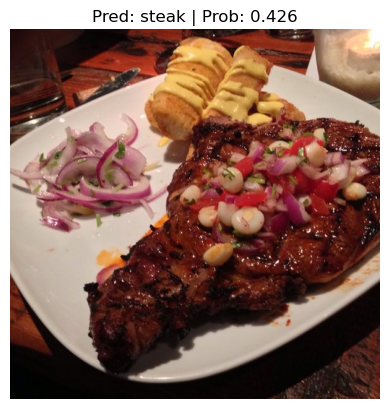

In [35]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from helper_functions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        # image_size=(224, 224)
                       )